In [25]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

In [163]:
# Hanrui's updated dataset
sps = pd.read_csv("../data/sps.csv")

In [171]:
sps.drop(columns=['dbsource'], inplace=True, errors='ignore') # dropping source of database

In [177]:
# one hot encoding for these columns
df = pd.get_dummies(sps, columns=['gender', 'admission_type', 'insurance', 'religion', 'marital_status', 'ethnicity', 'discharge_location', 'intervention.group'])

# survived if > a certain value
df['survived_90'] = df['survival_days'] > 1400

# doesn't work with NA columns
complete_cols = df.columns[df.isna().sum() == 0]

# split into cov/predictors and target (also some identifiers removed from X)
X = df[complete_cols].drop(columns=['subject_id', 'survival_days', 'survived_90', 'event'])
y = df['event']

Accuracy: 0.8223684210526315

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       125
           1       0.50      0.15      0.23        27

    accuracy                           0.82       152
   macro avg       0.67      0.56      0.56       152
weighted avg       0.78      0.82      0.78       152


Confusion Matrix:
 [[121   4]
 [ 23   4]]


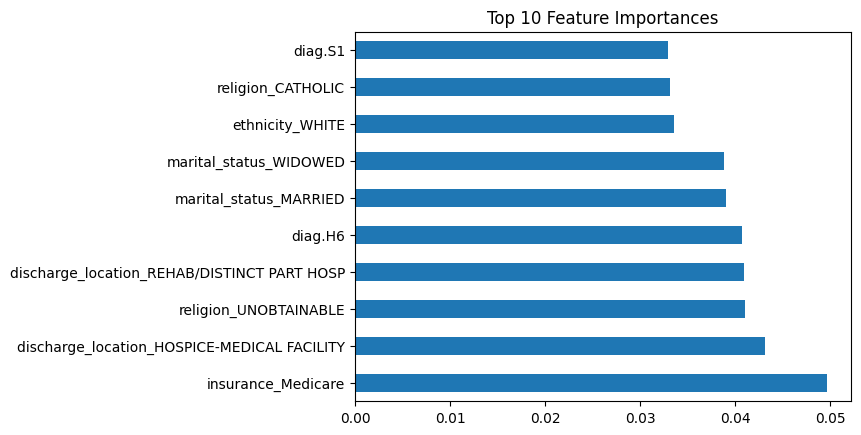

In [174]:
# Preprocessing


# Encode categorical variables if needed
le = LabelEncoder()
y = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize Random Forest
rf = RandomForestClassifier(
    n_estimators=100,      # Number of trees in the forest
    criterion='gini',      # Splitting criterion
    max_depth=None,        # Maximum depth of trees
    min_samples_split=2,   # Minimum samples required to split a node
    min_samples_leaf=1,    # Minimum samples required at each leaf node
    max_features='sqrt',   # Number of features to consider at each split
    random_state=42,       # Seed for reproducibility
    n_jobs=-1             # Use all available processors
)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importance visualization
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()

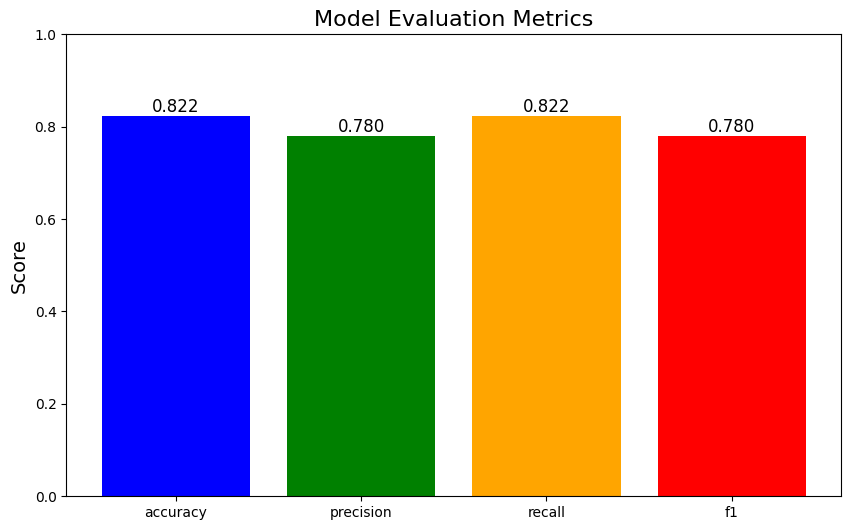

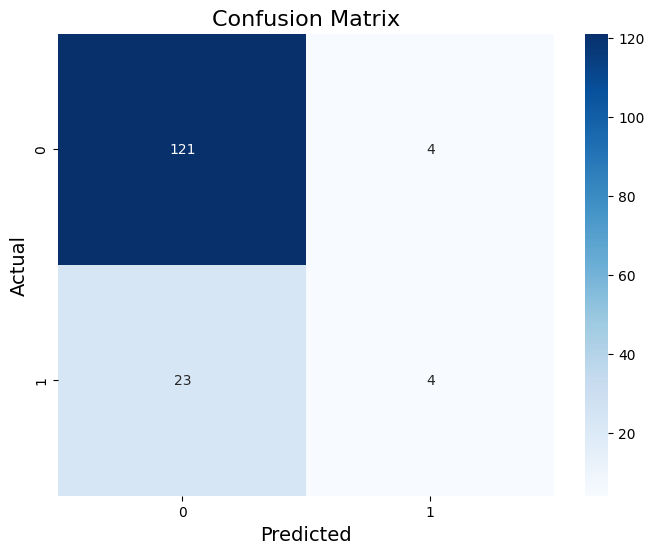

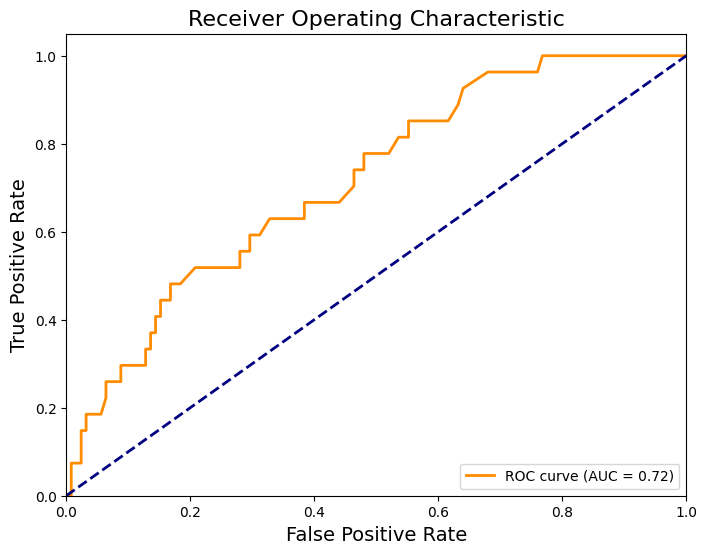

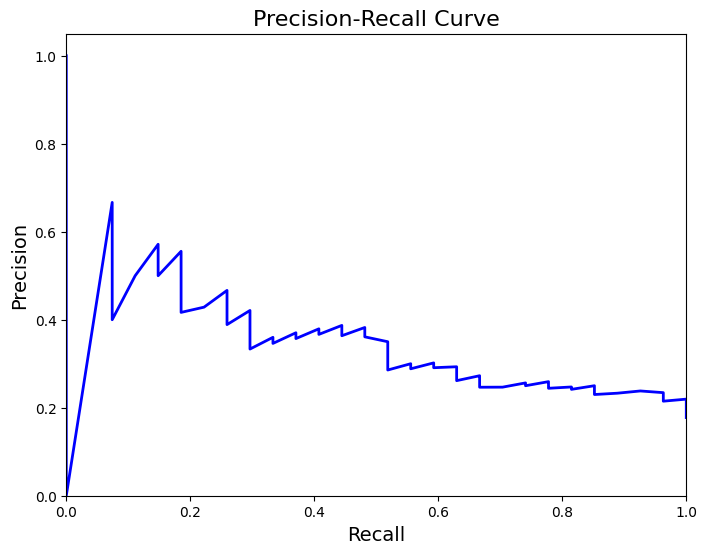

In [175]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import seaborn as sns

# 1. Basic Accuracy Plot (for classification report metrics)
metrics = ['accuracy', 'precision', 'recall', 'f1']
scores = [
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'),
    f1_score(y_test, y_pred, average='weighted')
]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color=['blue', 'green', 'orange', 'red'])
plt.title('Model Evaluation Metrics', fontsize=16)
plt.ylim(0, 1)
plt.ylabel('Score', fontsize=14)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=12)

plt.show()

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

# 3. ROC Curve (for binary classification)
if len(le.classes_) == 2:
    y_prob = rf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, 
                                            rf.predict_proba(X_test)[:, 1] if len(le.classes_) == 2 
                                            else rf.predict_proba(X_test).max(axis=1))
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

In [ ]:
sps['']

In [176]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} days")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f} days")
print(f"R²: {r2:.4f}")

MAE: 0.18 days
MSE: 0.18
RMSE: 0.42 days
R²: -0.2160


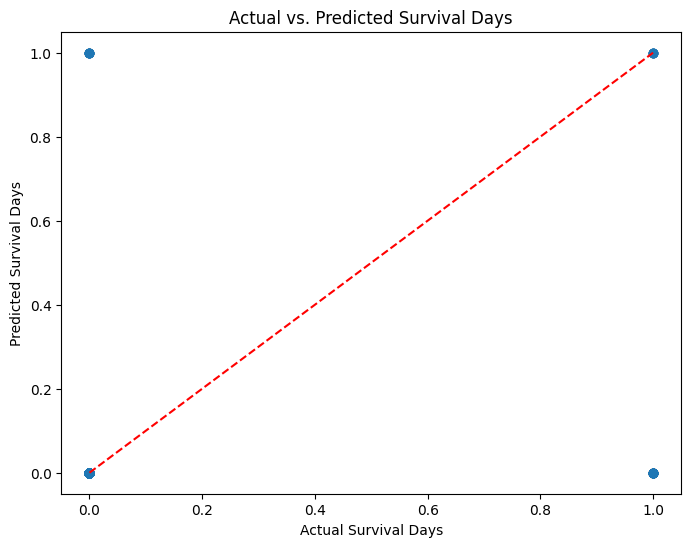

In [158]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Perfect prediction line
plt.xlabel("Actual Survival Days")
plt.ylabel("Predicted Survival Days")
plt.title("Actual vs. Predicted Survival Days")
plt.show()